First of all I want to mention that A/B test is not as simple as it seems at first glance. For a high-quality A/B test, it's crucial to properly model the experiment. This involves formulating a clear hypothesis—typically, the *Null hypothesis* (H0) states that there is no significant difference between the groups, while the *Alternative hypothesis* (H1) posits that there is a significant difference. Next, it's essential to choose the right metrics that will be impacted by the change being tested. Then we should select of randomization units for A/B test. One of the main aspects is calculating the required sample size. This should be done with a predetermined power and significance level (alpha), ensuring that these thresholds are not adjusted once the test begins, as doing so can invalidate the results. As well what help to calculate necessary sample size for A/B test is determining the minimum detectable effect (MDE). And also this helps set expectations for the smallest effect size that the test is designed to detect.

Given all these factors, it's clear that designing and executing an A/B test can be a complex, time-consuming, and resource-intensive process. In this pet project, we will explore techniques for analyzing A/B test data sourced from Kaggle

# Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random
import scipy.stats as stats
# parametric tests for ab testing
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# non-parametric tests for ab testing
from scipy.stats import mannwhitneyu

In [3]:
# load data and first look
df = pd.read_csv("/content/AB_Test_Results.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
# detailed information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
# let's check unique values by each group
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


# Data preprocessing

From that as we see, the number of unique users differs from the number of records, which is not good. That means the user could be in control group and variant group or appear multiple times in specific group what can make distortion of the result. Let's check this more detail.

In [6]:
temp = df.groupby("USER_ID")["VARIANT_NAME"].nunique().reset_index()
double_temp = temp[temp["VARIANT_NAME"] > 1]
print(f"Number of unique users what appear in each groups are {len(double_temp)}")
print(f"Number of unique users what appear in separate groups are {len(temp)-len(double_temp)}")

Number of unique users what appear in each groups are 1541
Number of unique users what appear in separate groups are 4783


In [7]:
double_df = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
(double_df / double_df.sum()).reset_index().rename(columns={"count": "percent_of_group"})

,VARIANT_NAME,percent_of_group
0,1,0.756325
1,2,0.243675


Here we can say that we have some problem with randomization because we have 24% of users in each A/B test group, we must inform about bad randomization split unit and choose another. If we don't do this, that will ruin all test.

In [8]:
# let's grab only users what exists in separate groups and save new dataframe
df = df[df["USER_ID"].isin(temp[temp["VARIANT_NAME"] == 1]["USER_ID"])]

Also, multiple existence of the one user within the same group can cause bias and incorrectness of the test. For example, we have one user who exists in a group of options and this user appears several times and each time he\she makes a purchase, so in this moment we can get incorrectness results, but these are rather inherent to the binomial distribution (buy/or not). As a result, we will not remove such users for large amounts of data we just sum up revenue by users. These issues should be considered during the A/B test planning period.

In [9]:
df = df.groupby(by=["USER_ID", "VARIANT_NAME"]).sum().reset_index()

# Short EDA

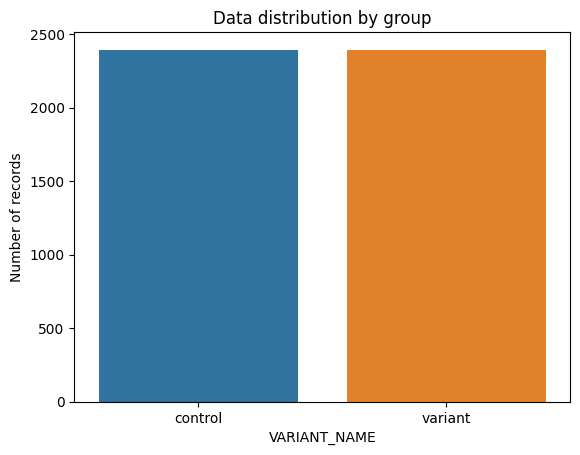

In [10]:
sns.countplot(data=df, x="VARIANT_NAME", hue="VARIANT_NAME")

plt.title("Data distribution by group")
plt.ylabel("Number of records")
plt.show()

see that in each group we approximately same number of records

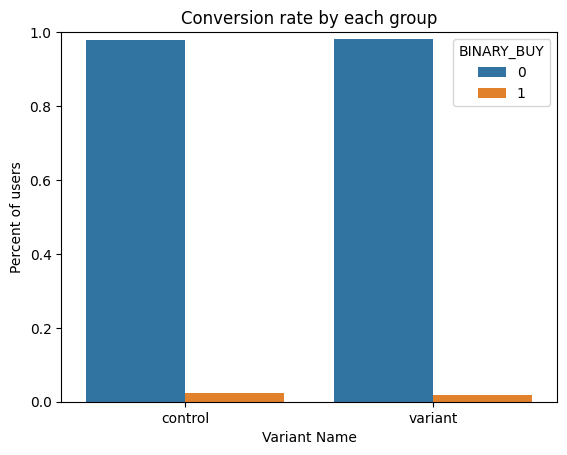

In [11]:
df["BINARY_BUY"] = df["REVENUE"].apply(lambda x: 1 if x > 0 else 0)
grouped_data = df.groupby("VARIANT_NAME")["BINARY_BUY"].value_counts(normalize=True).rename("percentage").reset_index()

sns.barplot(data=grouped_data, x="VARIANT_NAME", y="percentage", hue="BINARY_BUY")
plt.title("Conversion rate by each group")
plt.ylabel("Percent of users")
plt.xlabel("Variant Name")
plt.ylim(0, 1)
plt.show()

in this little project we comapre average revenue not conversion rate, means we don't really have to check this cnoversion, but I did it because wanna know how it differs between groups.

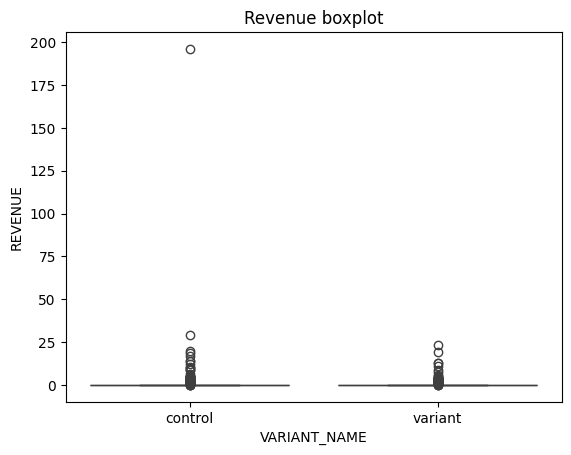

In [12]:
sns.boxplot(data=df, x="VARIANT_NAME", y="REVENUE")

plt.title("Revenue boxplot")
plt.show()

interesting, we have outlier in control group, let's check

In [13]:
df[df["VARIANT_NAME"] == "control"].sort_values(by="REVENUE", ascending=False).head()

,USER_ID,VARIANT_NAME,REVENUE,BINARY_BUY
1601,3342,control,196.01,1
1054,2166,control,29.32,1
514,1053,control,20.07,1
137,282,control,18.56,1
2150,4445,control,17.05,1


Indeed, we have an outlier here, let's check whether this user has made purchases yet

In [14]:
df[df["USER_ID"] == 3342]

,USER_ID,VARIANT_NAME,REVENUE,BINARY_BUY
1601,3342,control,196.01,1


no, then just delete this outlier for better test correctness and accuracy

In [15]:
df = df[df["USER_ID"] != 3342]

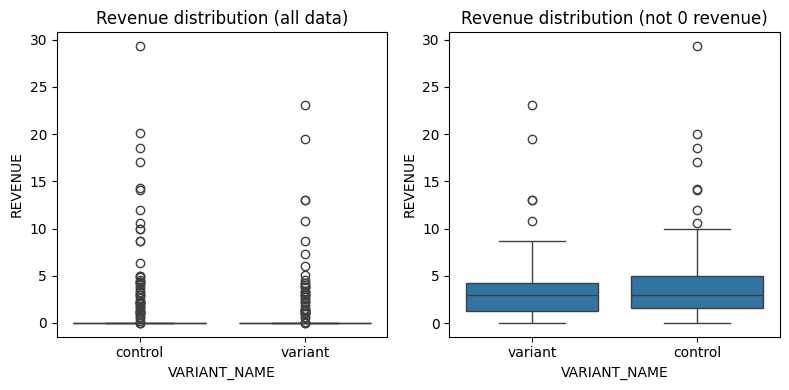

In [16]:
f, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(ax=axes[0], data=df, x="VARIANT_NAME", y="REVENUE")
axes[0].set_title("Revenue distribution (all data)")

sns.boxplot(ax=axes[1], data=df[df["REVENUE"] > 0], x="VARIANT_NAME", y="REVENUE")
axes[1].set_title("Revenue distribution (not 0 revenue)")

plt.tight_layout()
plt.show()

from the first boxplot we make sure that the most users don't buy product (something) and from the second we see that median revenue almost the same.

From here we don't know on what metrics for this A/B test we should specify, so let's try find as much useful data as possible.

In [17]:
# first of all let's check statistic by group
stat_group = df.groupby("VARIANT_NAME")["REVENUE"].agg(
    ["count", "sum", "mean", "median", "std"]).reset_index()
stat_group

,VARIANT_NAME,count,sum,mean,median,std
0,control,2389,274.55,0.114923,0.0,1.162495
1,variant,2393,179.32,0.074935,0.0,0.858207


here see that in variant group we have less total revenue and less revenue by user, but let's check situation in only payment users.

In [18]:
df[df["REVENUE"] != 0].groupby("VARIANT_NAME")["REVENUE"].agg(
    ["count", "sum", "mean", "median", "std"]).reset_index()

,VARIANT_NAME,count,sum,mean,median,std
0,control,53,274.55,5.180189,2.99,5.942771
1,variant,42,179.32,4.269524,2.97,4.962253


So, here we see that control group have more total revenue and revenue by user, but we actually see that median check almost the same, from this we can suggest that in control group we have more users with largest chek. In this situation we can't say for sure is that normal or we have another problem with randomization user split.

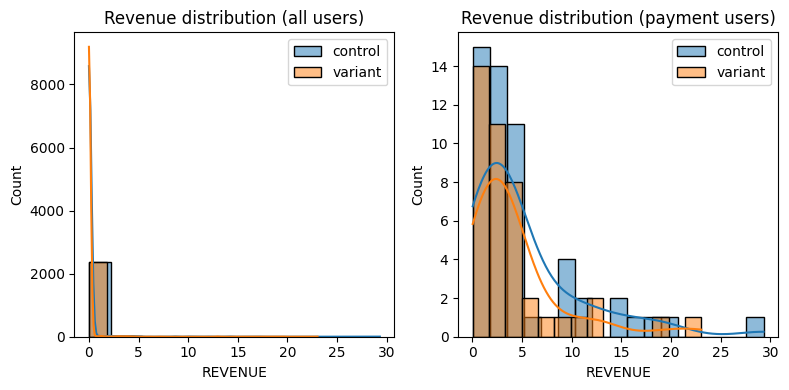

In [19]:
# let's see distribution of revenue

f, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(ax=axes[0], data=df[df["VARIANT_NAME"] == "control"],
             x="REVENUE", kde=True, label="control")
sns.histplot(ax=axes[0], data=df[df["VARIANT_NAME"] == "variant"],
             x="REVENUE", kde=True, label="variant")
axes[0].set_title("Revenue distribution (all users)")

sns.histplot(ax=axes[1],
             data=df[(df["VARIANT_NAME"] == "control") & (df["REVENUE"] != 0)],
             x="REVENUE", kde=True, label="control")
sns.histplot(ax=axes[1],
             data=df[(df["VARIANT_NAME"] == "variant") & (df["REVENUE"] != 0)],
             x="REVENUE", kde=True, label="variant")
axes[1].set_title("Revenue distribution (payment users)")

plt.tight_layout()
axes[0].legend()
axes[1].legend()
plt.show()

From this we can say sure that first and second plots don't have normal distribution of data, we can check this with QQ-plot

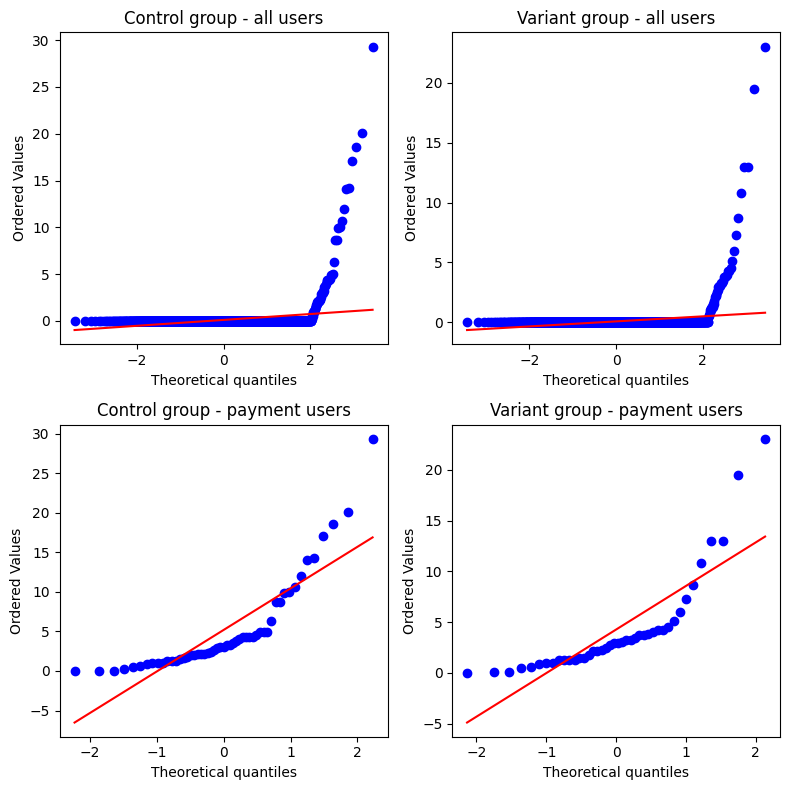

In [20]:
# let's make sure about it with QQplot
f, axes = plt.subplots(2, 2, figsize=(8, 8))

stats.probplot(df[df["VARIANT_NAME"] == "control"]["REVENUE"], dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Control group - all users")

stats.probplot(df[df["VARIANT_NAME"] == "variant"]["REVENUE"], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Variant group - all users")

stats.probplot(df[(df["VARIANT_NAME"] == "control") & (df["REVENUE"] != 0)]["REVENUE"], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Control group - payment users")

stats.probplot(df[(df["VARIANT_NAME"] == "variant") & (df["REVENUE"] != 0)]["REVENUE"], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Variant group - payment users")

plt.tight_layout()
plt.show()

For choosing the right test we not only should know specific data distribution is normal or not, we also should know distribution of mean value. If mean distribute normal that we can use parametric test, otherwise use just non-parametric test.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

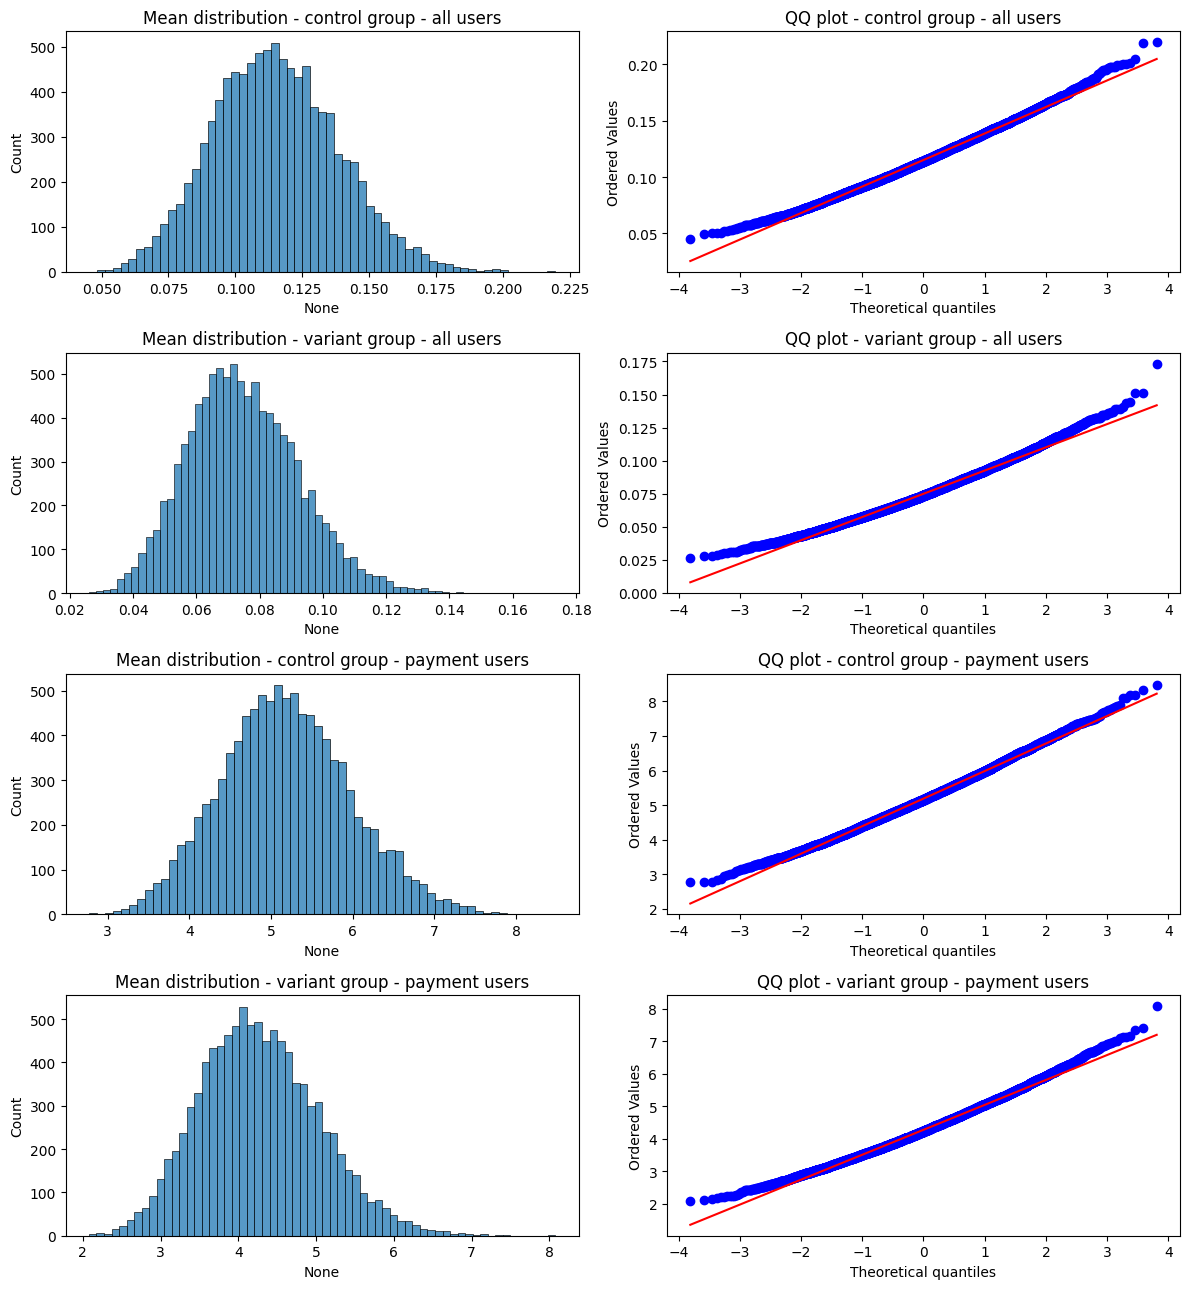

In [21]:
mean_distr_1 = pd.Series([df[df["VARIANT_NAME"] == "control"]["REVENUE"].sample(
    2389, replace=True).mean() for _ in tqdm(range(10000))])

mean_distr_2 = pd.Series([df[df["VARIANT_NAME"] == "variant"]["REVENUE"].sample(
    2393, replace=True).mean() for _ in tqdm(range(10000))])

mean_distr_3 = pd.Series([df[(df["VARIANT_NAME"] == "control") & (df["REVENUE"] != 0)]["REVENUE"].sample(
    53, replace=True).mean() for _ in tqdm(range(10000))])

mean_distr_4 = pd.Series([df[(df["VARIANT_NAME"] == "variant") & (df["REVENUE"] != 0)]["REVENUE"].sample(
    42, replace=True).mean() for _ in tqdm(range(10000))])

# Plotting
f, axes = plt.subplots(4, 2, figsize=(12, 13))

sns.histplot(ax=axes[0,0], x=mean_distr_1)
axes[0,0].set_title("Mean distribution - control group - all users")
stats.probplot(mean_distr_1, dist="norm", plot=axes[0,1])
axes[0,1].set_title("QQ plot - control group - all users")

sns.histplot(ax=axes[1,0], x=mean_distr_2)
axes[1,0].set_title("Mean distribution - variant group - all users")
stats.probplot(mean_distr_2, dist="norm", plot=axes[1,1])
axes[1,1].set_title("QQ plot - variant group - all users")

sns.histplot(ax=axes[2,0], x=mean_distr_3)
axes[2,0].set_title("Mean distribution - control group - payment users")
stats.probplot(mean_distr_3, dist="norm", plot=axes[2,1])
axes[2,1].set_title("QQ plot - control group - payment users")

sns.histplot(ax=axes[3,0], x=mean_distr_4)
axes[3,0].set_title("Mean distribution - variant group - payment users")
stats.probplot(mean_distr_4, dist="norm", plot=axes[3,1])
axes[3,1].set_title("QQ plot - variant group - payment users")

plt.tight_layout()
plt.show()

Here we can confidently say that mean values don't distribute normaly in each situation because we have skewness and we should use non-parametric statistical test.

# Statistics section of the project

So, let's make first Mann Whitney test on all users on this hypothesis:
* H0 - there is no significant difference in the average user check between the groups.
* H1 - there is a significant difference in the average user check between the groups.

In [22]:
mannwhitneyu(df[df["VARIANT_NAME"] == "control"]["REVENUE"],
             df[df["VARIANT_NAME"] == "variant"]["REVENUE"], alternative="two-sided")

MannwhitneyuResult(statistic=2871768.0, pvalue=0.24799555106821947)

Here we can't reject H0 (Null hypothesis). Let's check only payment users:

In [23]:
mannwhitneyu(df[(df["VARIANT_NAME"] == "control") & (df["REVENUE"] != 0)]["REVENUE"],
             df[(df["VARIANT_NAME"] == "variant") & (df["REVENUE"] != 0)]["REVENUE"], alternative="two-sided")

MannwhitneyuResult(statistic=1197.0, pvalue=0.5314192217084708)

Here we more sure to say that we can't reject H0. We did second test to be more sure in finish result, because there are a lot of repetitions in our sample (zero values), so in this case we need to be careful about this criterion.

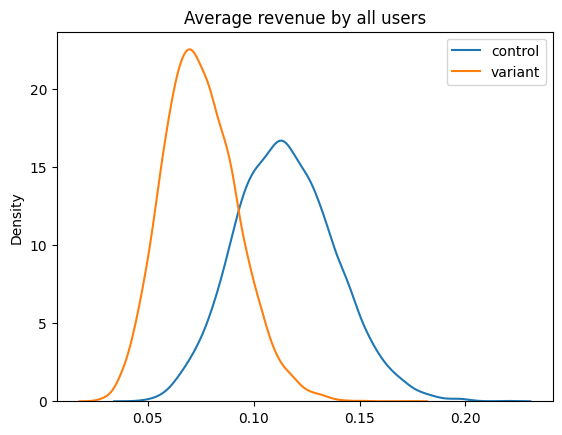

In [24]:
# let's compare means values between group

sns.kdeplot(mean_distr_1, label="control")
sns.kdeplot(mean_distr_2, label="variant")

plt.title("Average revenue by all users")
plt.legend()
plt.show()

see that variant group even worse than control, from this we can assume that our new change is not so good as we want it.

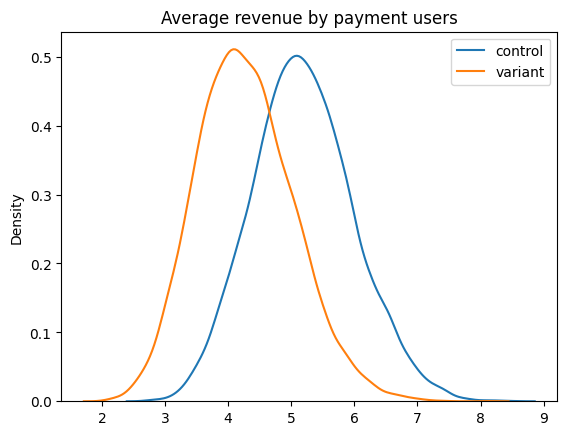

In [25]:
sns.kdeplot(mean_distr_3, label="control")
sns.kdeplot(mean_distr_4, label="variant")

plt.title("Average revenue by payment users")
plt.legend()
plt.show()

let's make bootstrap solution here:

In [43]:
# let's make mean differences with permutation_test
def permutation_test(x, nA, nB):
    n = nA + nB
    idx_A = list(random.sample(range(n), nA))
    idx_B = list(set(range(n)) - set(idx_A))
    return x["REVENUE"].iloc[idx_A].mean() - x["REVENUE"].iloc[idx_B].mean()


results = pd.Series([permutation_test(df, 2389, 2393) for _ in tqdm(range(10000))])

  0%|          | 0/10000 [00:00<?, ?it/s]

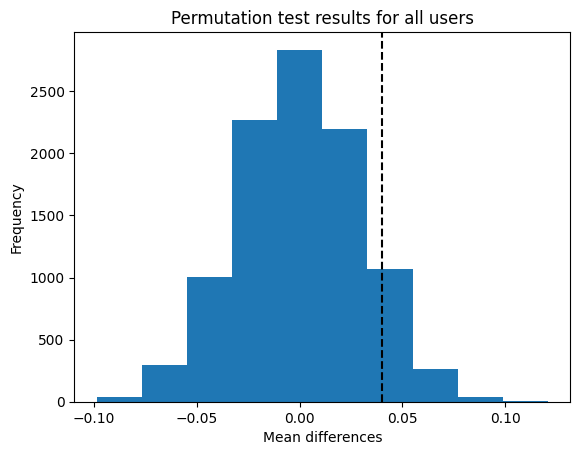

In [44]:
our_mean_diff = df[df["VARIANT_NAME"] == "control"]["REVENUE"].mean() - df[df["VARIANT_NAME"] == "variant"]["REVENUE"].mean()

plt.hist(results)
plt.axvline(x=our_mean_diff, linewidth=1.5, color="black", linestyle="dashed")
plt.title("Permutation test results for all users")
plt.xlabel("Mean differences")
plt.ylabel("Frequency")
plt.show()

Here we can say that our difference really is not significant, beacause our value (mean difference) deep exist within the range of random mean diffence variation, as we can see on the graph.

In [41]:
# the same test for only payment users
payment_results = pd.Series([permutation_test(df[df["REVENUE"] != 0], 53, 42) for _ in tqdm(range(10000))])

  0%|          | 0/10000 [00:00<?, ?it/s]

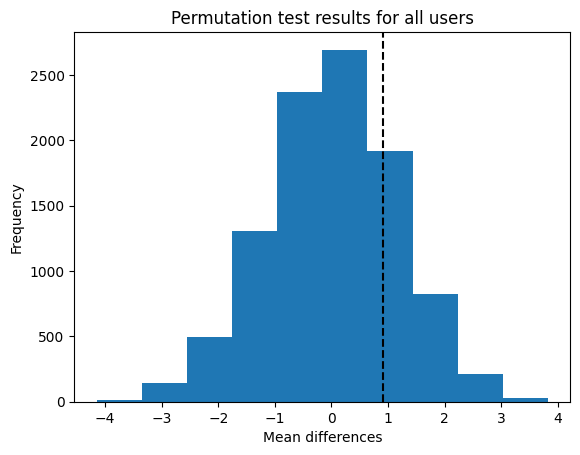

In [42]:
control_pay_group_mean = df[(df["VARIANT_NAME"] == "control") & (df["REVENUE"] != 0)]["REVENUE"].mean()
varinat_pay_group_mena = df[(df["VARIANT_NAME"] == "variant") & (df["REVENUE"] != 0)]["REVENUE"].mean()
our_mean_diff_pay = control_pay_group_mean - varinat_pay_group_mena

plt.hist(payment_results)
plt.axvline(x=our_mean_diff_pay, linewidth=1.5, color="black", linestyle="dashed")
plt.title("Permutation test results for all users")
plt.xlabel("Mean differences")
plt.ylabel("Frequency")
plt.show()

Here we can see the same result that our mean difference between the groups exist in range and are not significant. Also we can add 95% confidence interval on the graph, but it is not necessary because our mean difference deep in range of random mean differences.

# Conclusion

In this A/B testing project, we applied various methods and techniques, uncovering several important insights, such as issues with data collection, lack of proper randomization between groups, the presence of outliers, data distribution patterns, and the absence of significant differences between our metrics. There's nothing more to add; everything was explained earlier in the report.